# ZNE with indirect-control VQE
---

This experiment is:

- Qubit: 7, layer: 30
- System has noise-free time evolution.
- Target observable: Transverse field Ising Hamiltonian.
- Ansatz time-evolution: Noise-free time-evolution with XY, Ising, and Heisenberg Hamiltonians.
- Constraint: True

## (1) Import and setup

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

In [2]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 10

# Others
plot_titles = {
    "xy": "XY ansatz",
    "heisenberg": "Heisenberg ansatz",
    "ising": "Ising ansatz"
}

plot_export_names = {
    "xy": "xy_ansatz_noise_free_tevo.eps",
    "heisenberg": "heisenberg_ansatz_noise_free_tevo.eps",
    "ising": "ising_ansatz_noise_free_tevo.eps",
    "compiled": "compiled.eps",
    "heisenberg_further1": "heisenberg_ansatz_further_ric3.eps"
}

plot_colors = [
    "darkred",
    "darkgreen",
    "darkblue",
    "darkmagenta",
    "darkcyan",
    "magenta",
    "green",
    "goldenrod",
    "black",
    "orange",
    "purple"
    ]

## (2) Loading the experimental data from JSON files

The raw experimenal data are availabe at `data\` folder

In [3]:
base_path = "data"
models = ["xy", "ising", "heisenberg"]

ALL_RAW_DATA = {
    model: {
        "vqe": [],
        "redundant": [],
        "zne": [],
        "noiseoff": []  # Added to match the original structure
    } for model in models
}

for model in models:
    model_path = os.path.join(base_path, model)
    
    try:
        filenames = os.listdir(model_path)
    except Exception as e:
        print(f"[ERROR] Failed to list files in {model_path}: {e}")
        continue

    for filename in filenames:
        if not filename.endswith(".json"):
            continue

        filepath = os.path.join(model_path, filename)
        
        try:
            with open(filepath, "r") as f:
                data = json.load(f)
        except json.JSONDecodeError:
            print(f"[ERROR] Failed to parse JSON in file: {filepath}")
            continue
        except Exception as e:
            print(f"[ERROR] Failed to load file {filepath}: {e}")
            continue

        filename_lower = filename.lower()
        if filename_lower.endswith("_vqe.json"):
            ALL_RAW_DATA[model]["vqe"].append(data)
        elif filename_lower.endswith("_redundant.json"):
            ALL_RAW_DATA[model]["redundant"].append(data)
        elif filename_lower.endswith("_zne.json"):
            ALL_RAW_DATA[model]["zne"].append(data)
        elif filename_lower.endswith("_noise_off.json"):
            ALL_RAW_DATA[model]["noiseoff"].append(data)


## (3) Extracting data

<img src="../../figures/quantum_cicuit_standard_vs_redundant.jpg" alt="std_vs_redun_circuit" width="800"/>


Now lets extract some unformations.




### (A) The exact minimum eigen value

Our target Hamiltonian is

$$H_{Ising} = \sum_{k=1}^{N-1} X_{k}X_{k+1} + \sum_{k=1}^{N}Z_k$$

where $N=7$.

The exact minimum eigen value of the target observable (i.e. tranverse field Ising Hamiltonian for a 7-qubit system) is $-8.566772233505624$. This value is recored in `file_name_prefix_ZNE.json` files.

In [4]:
exact_sol: float = -8.566772233505624
print(f"Exact solution: {exact_sol}")

Exact solution: -8.566772233505624


### (B) VQE estimations (noise is on)

The noise level ($\lambda$) is defined as 
$$\lambda = n_R + 2 n_{CZ} + N n_T + n_Y$$

where $nR, n_{CZ}, n_T, $ and $nY$ are proportinal to number of *noisy* rotation gates, two-qubit $CZ$ gate, the time-evolution gates, and Y gates. For the above circuit in the standard circuit (i.e. unboosted noise) noise level is $6$ while in the redundant circuit (i.e. boosted noise) noise level is $18$.

In [5]:
noise_levels: int=[6, 18]
extrapolated_noise: int = 0

### (C) Processing raw data

In [6]:
ALL_PROCESSED_DATA = {
    model: {
        "vqe": {},
        "redundant": {},
        "zne": {},
        "noiseoff": {}  # Added to match the original structure
    } for model in models
}

for model in models:
    
    ALL_PROCESSED_DATA[model]["vqe"] = {
        "mean": np.mean(
                    ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]
                ),
        "std": np.std(
            ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]
        )
    }

    ALL_PROCESSED_DATA[model]["redundant"] = {
        "noise_levels": noise_levels,
        "mean": [
            np.mean(
                [ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][0][4] for i in range(len(ALL_RAW_DATA[model]["redundant"]))]

            ),
            np.mean(
                [ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][1][4] for i in range(len(ALL_RAW_DATA[model]["redundant"]))]

            )
        ],
        "std": [
            np.std(
                [ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][0][4] for i in range(len(ALL_RAW_DATA[model]["redundant"]))]

            ),
            np.std(
                [ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][1][4] for i in range(len(ALL_RAW_DATA[model]["redundant"]))]

            )
        ],
    }

    ALL_PROCESSED_DATA[model]["zne"] = {
        "mean": np.mean(
            [ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"]for i in range(len(ALL_RAW_DATA[model]["zne"]))]
        ),
        "std": np.std(
            [ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"]for i in range(len(ALL_RAW_DATA[model]["zne"]))]
        )
    }

    ALL_PROCESSED_DATA[model]["noiseoff"] = {
        "mean": np.mean(
            ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]
        ),
        "std": np.std(
            ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]
        )
    }

In [7]:
ALL_PROCESSED_DATA

{'xy': {'vqe': {'mean': -7.379092083216174, 'std': 0.14051949985579798},
  'redundant': {'noise_levels': [6, 18],
   'mean': [-7.379092083216115, -5.824916251047478],
   'std': [0.14051949985579046, 0.1477491400189833]},
  'zne': {'mean': -8.156179999300434, 'std': 0.14316522047529734},
  'noiseoff': {'mean': -8.369342611101047, 'std': 0.15124979844206457}},
 'ising': {'vqe': {'mean': -6.583152545992618, 'std': 0.18915423038578477},
  'redundant': {'noise_levels': [6, 18],
   'mean': [-6.583152545992628, -5.380444453773971],
   'std': [0.1891542303858077, 0.2113251022452117]},
  'zne': {'mean': -7.184506592101956, 'std': 0.18074166336647968},
  'noiseoff': {'mean': -7.2800222505553736, 'std': 0.24690963596051196}},
 'heisenberg': {'vqe': {'mean': -6.056457299952753, 'std': 0.1806957231807042},
  'redundant': {'noise_levels': [6, 18],
   'mean': [-6.056457299952717, -4.591528569882986],
   'std': [0.18069572318071422, 0.17227869097031923]},
  'zne': {'mean': -6.788921664987581, 'std': 0

In [8]:
# Prepare rows for tabulation
rows = []
for model, methods in ALL_PROCESSED_DATA.items():
    for method, stats in methods.items():
        if method == "redundant":
            for lvl, m, s in zip(stats['noise_levels'], stats['mean'], stats['std']):
                rows.append([model, f"{method} (noise={lvl})", m, s])
        elif stats:  # ignore empty "noiseoff"
            rows.append([model, method, stats['mean'], stats['std']])
        else:
            rows.append([model, method, "N/A", "N/A"])

# Print table
headers = ["Model", "Category", "Mean", "Std"]
print(tabulate(rows, headers=headers))

Model       Category                  Mean       Std
----------  --------------------  --------  --------
xy          vqe                   -7.37909  0.140519
xy          redundant (noise=6)   -7.37909  0.140519
xy          redundant (noise=18)  -5.82492  0.147749
xy          zne                   -8.15618  0.143165
xy          noiseoff              -8.36934  0.15125
ising       vqe                   -6.58315  0.189154
ising       redundant (noise=6)   -6.58315  0.189154
ising       redundant (noise=18)  -5.38044  0.211325
ising       zne                   -7.18451  0.180742
ising       noiseoff              -7.28002  0.24691
heisenberg  vqe                   -6.05646  0.180696
heisenberg  redundant (noise=6)   -6.05646  0.180696
heisenberg  redundant (noise=18)  -4.59153  0.172279
heisenberg  zne                   -6.78892  0.194212
heisenberg  noiseoff              -6.92055  0.197668


## (4) Plot

Finally we can plot the results.

### (A) XY ansatz plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


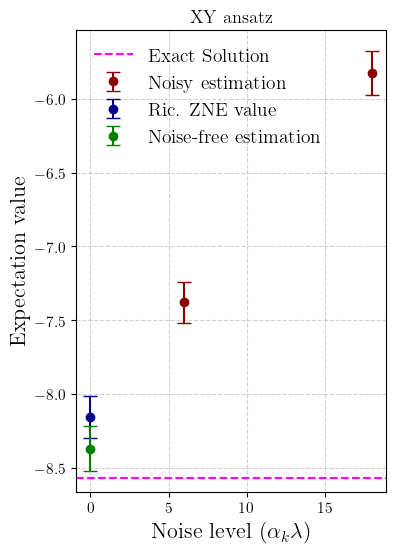

Figure saved as (in 'plots' folder): xy_ansatz_ric.eps


In [9]:
# Plot size
plt.figure(figsize=(4, 6))
# PLot name
plot_name: str= "xy_ansatz_ric.eps"
DATA= ALL_PROCESSED_DATA["xy"]

# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=extrapolated_noise, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["xy"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_name)

### (B) Ising ansatz plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


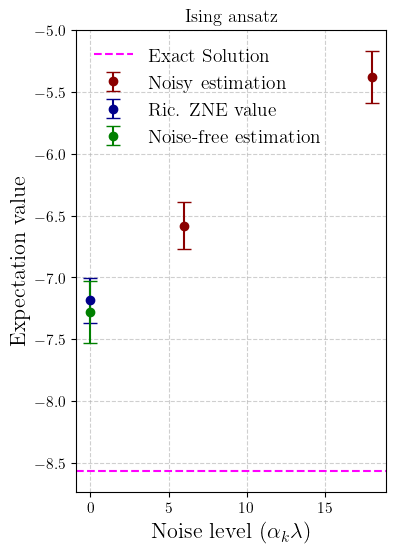

Figure saved as (in 'plots' folder): ising_ansatz_ric.eps


In [10]:
# Plot size
plt.figure(figsize=(4, 6))
# PLot name
plot_name: str= "ising_ansatz_ric.eps"
DATA= ALL_PROCESSED_DATA["ising"]

# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=extrapolated_noise, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["ising"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_name)

### (C) Heisenberg ansatz plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


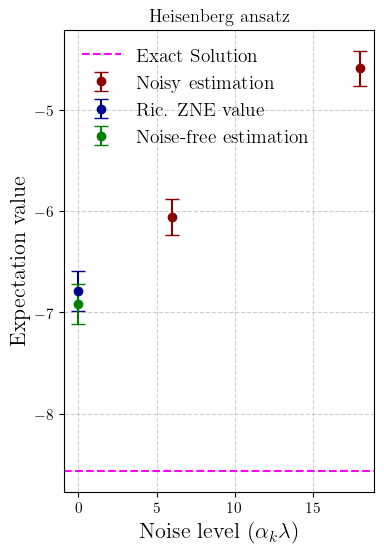

Figure saved as (in 'plots' folder): hesisenberg_ansatz_ric.eps


In [11]:
# Plot size
plt.figure(figsize=(4, 6))
# PLot name
plot_name: str= "hesisenberg_ansatz_ric.eps"
DATA= ALL_PROCESSED_DATA["heisenberg"]

# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=extrapolated_noise, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_name)

## (5) Compiled plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


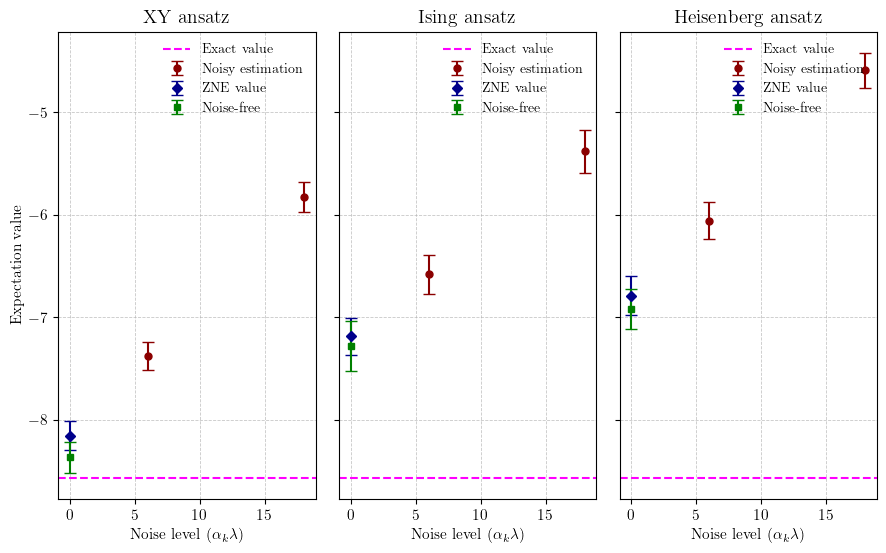

In [22]:
plot_name: str = "compiled_ansatz_noise_free_tevo.eps"
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 6), sharey=True)

for i, model in enumerate(["xy", "ising", "heisenberg"]):
    ax = axs[i]
    DATA = ALL_PROCESSED_DATA[model]

    # Noisy Estimation
    ax.errorbar(
        x=noise_levels,
        y=DATA["redundant"]["mean"],
        yerr=DATA["redundant"]["std"],
        fmt="o",
        ecolor=plot_colors[0],
        capsize=4,
        label="Noisy estimation",
        color=plot_colors[0],
        markersize=5
    )

    # ZNE Extrapolated
    ax.errorbar(
        x=extrapolated_noise,
        y=DATA["zne"]["mean"],
        yerr=DATA["zne"]["std"],
        fmt="D",
        ecolor=plot_colors[2],
        capsize=4,
        label="ZNE value",
        color=plot_colors[2],
        markersize=5
    )

    # Noise-free Estimation
    ax.errorbar(
        x=0,
        y=DATA["noiseoff"]["mean"],
        yerr=DATA["noiseoff"]["std"],
        fmt="s",
        ecolor=plot_colors[6],
        capsize=4,
        label="Noise-free",
        color=plot_colors[6],
        markersize=5
    )

    # Exact Value
    ax.axhline(
        y=exact_sol,
        color=plot_colors[5],
        linestyle="--",
        linewidth=1.5,
        label="Exact value"
    )

    # Titles and Labels
    ax.set_title(plot_titles[model], fontsize=14)
    ax.set_xlabel(r"Noise level ($\alpha_k\lambda$)")
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)

    if i == 0:
        ax.set_ylabel("Expectation value")

    # ✅ Legend in top right
    ax.legend(loc="upper right", frameon=False)

# Layout tweaks
plt.tight_layout(w_pad=1.2, h_pad=0.3)
plt.subplots_adjust(top=0.88)

# Optional: Save
plt.savefig(f"plots/{plot_name}", format="eps")

plt.show()


---

## (5) Further studies on Heisenberg ansatz

### (A) Load JSON data

In [25]:
# Define the base path to "heisenberg_further"
heisenberg_further_path = os.path.join(base_path, "heisenberg-further")

# Define new paths for each category
ric3_path = os.path.join(heisenberg_further_path, "ric3")
ricmul_path = os.path.join(heisenberg_further_path, "ricmul")

# Initialize the data dictionary
heisenberg_further_data: dict = {"ric3": [], "ricmul": []}

# Function to load JSONs from a given folder
def load_json_files(folder_path):
    data_list = []
    if os.path.exists(folder_path):
        json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
        for json_file in json_files:
            file_path = os.path.join(folder_path, json_file)
            with open(file_path, "r") as f:
                data_list.append(json.load(f))
    else:
        print(f"Folder {folder_path} not found.")
    return data_list

# Load JSONs from each folder
heisenberg_further_data["ric3"] = load_json_files(ric3_path)
heisenberg_further_data["ricmul"] = load_json_files(ricmul_path)

# Print summary
print(f"3-point Richardson ZNE: Loaded {len(heisenberg_further_data['ric3'])} JSON files from 'ric3' folder.")
print(f"Multivariate Richardson ZNE: Loaded {len(heisenberg_further_data['ricmul'])} JSON files from 'ricmul' folder.")


3-point Richardson ZNE: Loaded 20 JSON files from 'ric3' folder.
Multivariate Richardson ZNE: Loaded 20 JSON files from 'ricmul' folder.


### (B) Noisy VQE values



In [ ]:
ALL_PROCESSED_DATA = {
    model: {
        "vqe": {},
        "redundant": {},
        "zne": {},
        "noiseoff": {}  # Added to match the original structure
    } for model in models
}

# Extract sampled data arrays for both XY and Heisenberg ansätze
heisenberg_ric3 = [entry["output"]["zne_values"]["sampled data"] for entry in heisenberg_further_data["ric3"]]
heisenberg_mul = [entry["output"]["zne_values"]["sampled data"] for entry in heisenberg_further_data["ricmul"]]

# Compute noisy VQE statistics
noisy_vqe_vals_further: dict = {
    "ric3": {
        "mean": [
            np.mean([sample[0][4] for sample in heisenberg_ric3]),  # Unboosted (noise level 6)
            np.mean([sample[1][4] for sample in heisenberg_ric3]),  # Boosted (noise level 18)
            np.mean([sample[2][4] for sample in heisenberg_ric3]), # Bossted (noise level 26)
        ],
        "std": [
            np.std([sample[0][4] for sample in heisenberg_ric3]),   # Unboosted
            np.std([sample[1][4] for sample in heisenberg_ric3]),   # Boosted
            np.std([sample[2][4] for sample in heisenberg_ric3])    # Boosted
        ],
    },
    "ricmul": {
        "mean": [
            np.mean([sample[0][2] for sample in heisenberg_mul]),  # Unboosted
            np.mean([sample[1][2] for sample in heisenberg_mul]),  # Boosted
            np.mean([sample[2][2] for sample in heisenberg_mul])    # Boosted
        ],
        "std": [
            np.std([sample[0][2] for sample in heisenberg_mul]),   # Unboosted
            np.std([sample[1][2] for sample in heisenberg_mul]),   # Boosted
            np.std([sample[2][2] for sample in heisenberg_mul]),   # Boosted
        ],
    },
}
# Lets print the values as well
# Labels
headers = ["Description", "Noise Level", "Mean", "Std Dev"]

# Data rows
rows = [
    ["Heisenberg (ric3)", "Unboosted (noise 4)", noisy_vqe_vals_further["ric3"]["mean"][0], noisy_vqe_vals_further["ric3"]["std"][0]],
    ["Heisenberg (ric3)", "Boosted (noise 18)", noisy_vqe_vals_further["ric3"]["mean"][1], noisy_vqe_vals_further["ric3"]["std"][1]],
    ["Heisenberg (ric3)", "Boosted (noise 26)", noisy_vqe_vals_further["ric3"]["mean"][2], noisy_vqe_vals_further["ric3"]["std"][2]],
    ["Heisenberg (ricmul)", "Unboosted (noise [4, 2])", noisy_vqe_vals_further["ricmul"]["mean"][0], noisy_vqe_vals_further["ricmul"]["std"][0]],
    ["Heisenberg (ricmul)", "Boosted (noise [12, 6])", noisy_vqe_vals_further["ricmul"]["mean"][1], noisy_vqe_vals_further["ricmul"]["std"][1]],
    ["Heisenberg (ricmul)", "Boosted (noise [20, 6])", noisy_vqe_vals_further["ricmul"]["mean"][2], noisy_vqe_vals_further["ricmul"]["std"][2]],
]

# Print table
print(tabulate(rows, headers=headers, floatfmt=".6f", tablefmt="grid"))

KeyError: 'zne_values'

### (C) 3-point ZNE estimations

In [18]:
heisenberg_further_zne_vals : dict={
    "ric3": {
        "mean": np.mean([entry["output"]["zne_values"]["extrapolated_value"] for entry in heisenberg_further_data["ric3"]]),
        "std": np.std([entry["output"]["zne_values"]["extrapolated_value"] for entry in heisenberg_further_data["ric3"]])
    },
    "ricmul": {
        "mean": np.mean([entry["output"]["zne_values"]["extrapolated_value"] for entry in heisenberg_further_data["ricmul"]]),
        "std": np.std([entry["output"]["zne_values"]["extrapolated_value"] for entry in heisenberg_further_data["ricmul"]])
    }
}

# Prepare data for tabulate
headers = ["Description", "Mean", "Std Dev"]
rows = [
    ["Heisenberg (ric2)", zne_vals["heisenberg"]["mean"], zne_vals["heisenberg"]["std"]],
    ["Heisenberg (ric3)", heisenberg_further_zne_vals["ric3"]["mean"], heisenberg_further_zne_vals["ric3"]["std"]],
    ["Heisenberg (ricmul)", heisenberg_further_zne_vals["ricmul"]["mean"], heisenberg_further_zne_vals["ricmul"]["std"]],
]

# Print the table
print("Comparison between 2 point ZNE, 3-point ZNE and multivariate ZNE")
print(tabulate(rows, headers=headers, floatfmt=".15f", tablefmt="grid"))

NameError: name 'zne_vals' is not defined

### (D) Plot

In [ ]:
# Plot size
plt.figure(figsize=(4, 6))
# PLot name
plot_name: str= "heisen_3point_zne.eps"

noise_levels = [6, 18, 26]
# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=noisy_vqe_vals_further["ric3"]["mean"],
    yerr=noisy_vqe_vals_further["ric3"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# 2-point Richardson ZNE
plt.errorbar(
    x=extrapolated_noise, 
    y=zne_vals["heisenberg"]["mean"], 
    yerr=zne_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value (2-point)", 
    color=plot_colors[2]
)
# 3-pont Richardson ZNE
plt.errorbar(
    x=extrapolated_noise, 
    y=heisenberg_further_zne_vals["ric3"]["mean"], 
    yerr=heisenberg_further_zne_vals["ric3"]["std"], 
    fmt="o", 
    ecolor=plot_colors[3],
    capsize=5, 
    label="Ric. ZNE value (3-point)", 
    color=plot_colors[3]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=noise_off_vqe_vals["heisenberg"]["mean"], 
    yerr=noise_off_vqe_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)")
plt.ylabel("Expectation value")
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):", {plot_export_names['heisenberg']})

In [ ]:
# Plot size
plt.figure(figsize=(4, 6))
# PLot name
plot_name: str= "heisen_mulvar_zne.eps"

# Map noise levels to numeric x-axis positions
x_labels = ["(0,0)", "(4,2)", "(12,6)", "(20,6)"]
x_positions = list(range(len(x_labels)))  # [0, 1, 2, 3]

# Plot Noise-free estimation (position 0)
plt.errorbar(
    x=x_positions[0], 
    y=noise_off_vqe_vals["heisenberg"]["mean"], 
    yerr=noise_off_vqe_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)

# Noisy estimations (positions 1, 2, 3)
plt.errorbar(
    x=x_positions[1:], 
    y=noisy_vqe_vals_further["ric3"]["mean"], 
    yerr=noisy_vqe_vals_further["ric3"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)

# ZNE (position 0)

# 2-point Richardson ZNE (corresponding noise levels are 6 and 18)
plt.errorbar(
    x=x_positions[0], 
    y=zne_vals["heisenberg"]["mean"], 
    yerr=zne_vals["heisenberg"]["std"], 
    fmt="D", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value (2-point)", 
    color=plot_colors[2]
)
# 3-point Richardson ZNE (corresponding noise levels are 6, 18, 26)
plt.errorbar(
    x=x_positions[0], 
    y=heisenberg_further_zne_vals["ric3"]["mean"], 
    yerr=heisenberg_further_zne_vals["ric3"]["std"], 
    fmt="*", 
    ecolor=plot_colors[3],
    capsize=5, 
    label="Ric. ZNE value (3-point)", 
    color=plot_colors[3]
)

# Multivatiate Richardson ZNE (2 independent variables, degree 1)
plt.errorbar(
    x=x_positions[0], 
    y=heisenberg_further_zne_vals["ricmul"]["mean"], 
    yerr=heisenberg_further_zne_vals["ricmul"]["std"], 
    fmt=".", 
    ecolor=plot_colors[4],
    capsize=5, 
    label="Ricmul. ZNE value (3-point)", 
    color=plot_colors[4]
)

# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label="Exact Solution")

# X-axis labels and ticks
plt.xticks(ticks=x_positions, labels=x_labels)

# Labels and title
plt.xlabel(r"Noise level ($n_R, n_{CZ}$)")
plt.ylabel("Expectation value")
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", frameon=False)

# Save as EPS
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()

print("Figure saved as (in 'plots' folder):", {plot_export_names['heisenberg']})

In [ ]:
# Create combined figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(6, 6), sharey=True)

# ----------------------------------------
# Subplot 1: Single-variable ZNE (left)
# ----------------------------------------
ax = axs[0]
noise_levels = [6, 18, 26]

# Noisy estimation
ax.errorbar(
    x=noise_levels,
    y=noisy_vqe_vals_further["ric3"]["mean"],
    yerr=noisy_vqe_vals_further["ric3"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)

# 2-point Richardson ZNE
ax.errorbar(
    x=extrapolated_noise, 
    y=zne_vals["heisenberg"]["mean"], 
    yerr=zne_vals["heisenberg"]["std"], 
    fmt="D", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE (2-point)", 
    color=plot_colors[2]
)

# 3-point Richardson ZNE
ax.errorbar(
    x=extrapolated_noise, 
    y=heisenberg_further_zne_vals["ric3"]["mean"], 
    yerr=heisenberg_further_zne_vals["ric3"]["std"], 
    fmt="*", 
    ecolor=plot_colors[3],
    capsize=5, 
    label="Ric. ZNE (3-point)", 
    color=plot_colors[3]
)

# Noise-free estimation
ax.errorbar(
    x=0, 
    y=noise_off_vqe_vals["heisenberg"]["mean"], 
    yerr=noise_off_vqe_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free", 
    color=plot_colors[6]
)

# Exact solution
ax.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label="Exact solution")

# Labels and styling
ax.set_xlabel(r"Noise level ($\alpha_k\lambda$)")
ax.set_ylabel("Expectation value")
ax.set_title("Single-variable ZNE")
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(loc="upper left", frameon=False)

# ----------------------------------------
# Subplot 2: Multivariate ZNE (right)
# ----------------------------------------
ax = axs[1]
x_labels = ["(0,0)", "(4,2)", "(12,6)", "(20,6)"]
x_positions = list(range(len(x_labels)))

# Noise-free estimation (position 0)
ax.errorbar(
    x=x_positions[0], 
    y=noise_off_vqe_vals["heisenberg"]["mean"], 
    yerr=noise_off_vqe_vals["heisenberg"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free", 
    color=plot_colors[6]
)

# Noisy estimations (positions 1, 2, 3)
ax.errorbar(
    x=x_positions[1:], 
    y=noisy_vqe_vals_further["ric3"]["mean"], 
    yerr=noisy_vqe_vals_further["ric3"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)

# 2-point Richardson ZNE
ax.errorbar(
    x=x_positions[0], 
    y=zne_vals["heisenberg"]["mean"], 
    yerr=zne_vals["heisenberg"]["std"], 
    fmt="D", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE (2-point)", 
    color=plot_colors[2]
)

# 3-point Richardson ZNE
ax.errorbar(
    x=x_positions[0], 
    y=heisenberg_further_zne_vals["ric3"]["mean"], 
    yerr=heisenberg_further_zne_vals["ric3"]["std"], 
    fmt="*", 
    ecolor=plot_colors[3],
    capsize=5, 
    label="Ric. ZNE (3-point)", 
    color=plot_colors[3]
)

# Multivariate ZNE
ax.errorbar(
    x=x_positions[0], 
    y=heisenberg_further_zne_vals["ricmul"]["mean"], 
    yerr=heisenberg_further_zne_vals["ricmul"]["std"], 
    fmt=".", 
    ecolor=plot_colors[4],
    capsize=5, 
    label="Ricmul. ZNE", 
    color=plot_colors[4]
)

# Exact solution
ax.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label="Exact solution")

# Labels and styling
ax.set_xlabel(r"Noise level ($n_R, n_{CZ}$)")
ax.set_title("Multivariate ZNE")
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(loc="upper left", frameon=False)

# ----------------------------------------
# Finalize and save
# ----------------------------------------
plt.tight_layout()
plt.savefig("plots/heisen_combined_zne.eps", format="eps")
plt.show()


---

Now for the 3-point ZNE, lets choose a different set of identity factors. In other words, we will be using different noisy estimations for extrapolation.

In [ ]:
# Define the path to the "heisenberg_further2" folder
heisenberg_further2_path = os.path.join(base_path, "heisenberg_further2")

# Initialize a dictionary to store the data from the JSON files
heisenberg_further2_data: dict = {"zne": []}

# Check if the folder exists
if os.path.exists(heisenberg_further2_path):
    # List all JSON files in the folder
    json_files = [f for f in os.listdir(heisenberg_further2_path) if f.endswith(".json")]
    
    # Load each JSON file and categorize based on the filename
    for json_file in json_files:
        file_path = os.path.join(heisenberg_further2_path, json_file)
        with open(file_path, "r") as f:
            data = json.load(f)
            if "zne" in json_file.lower():
                heisenberg_further2_data["zne"].append(data)

else:
    print(f"Folder {heisenberg_further2_path} not found.")

# Print the number of files loaded for each category
print(f"3-point Richardson ZNE: Loaded {len(heisenberg_further2_data['zne'])} JSON files with 'zne' in their name.")

In [ ]:
heisenberg_further2_zne_mean: float= np.mean([entry["output"]["zne_values"]["extrapolated_value"] for entry in heisenberg_further2_data["zne"]])
heisenberg_further2_zne_std: float= np.std([entry["output"]["zne_values"]["extrapolated_value"] for entry in heisenberg_further2_data["zne"]])
noise_further_2_noise = [6, 18, 30]
noisy_vqe_vals_further2_mean: float= np.mean([entry["output"]["zne_values"]["sampled data"][2][4] for entry in heisenberg_further2_data["zne"]])
noisy_vqe_vals_further2_std: float= np.std([entry["output"]["zne_values"]["sampled data"][2][4] for entry in heisenberg_further2_data["zne"]])

In [ ]:
df = pd.json_normalize(heisenberg_further2_data["zne"])
# Truncate the 'config.init_param.value' column if it exists
col_name = 'config.init_param.value'
if col_name in df.columns:
    df[col_name] = df[col_name].apply(lambda x: str(x)[:30] + "..." if len(str(x)) > 30 else str(x))
# Print tabulated data for heisenberg further studies 2
print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))

In [ ]:
# Plot setup
plt.figure(figsize=(4, 6))
# PLot name
plot_name: str= "heisen_3point_ZNE2.eps"


x_labels = ["(0,0)", "(4,2)", "(12,6)", "(20,6)", "(20,10)"]
x_positions = list(range(len(x_labels)))

# === Noise-free estimation at (0,0) ===
plt.errorbar(
    x=x_positions[0],
    y=noise_off_vqe_vals["heisenberg"]["mean"],
    yerr=noise_off_vqe_vals["heisenberg"]["std"],
    fmt="o",
    color=plot_colors[6],
    ecolor=plot_colors[6],
    capsize=5,
    label="Noise-free estimation"
)

# === Noisy estimations ===
# From (4,2), (12,6), (20,6)
plt.errorbar(
    x=[1, 2, 3],
    y=noisy_vqe_vals_further["ric3"]["mean"],
    yerr=noisy_vqe_vals_further["ric3"]["std"],
    fmt="o",
    color=plot_colors[0],
    ecolor=plot_colors[0],
    capsize=5,
    label="Noisy estimations"
)

# From (20,10)
plt.errorbar(
    x=[4],
    y=noisy_vqe_vals_further2_mean,
    yerr=noisy_vqe_vals_further2_std,
    fmt="o",
    color=plot_colors[0],
    ecolor=plot_colors[0],
    capsize=5
)

# === Extrapolated ZNE values (always plotted at (0,0)) ===
# 2-point Richardson ZNE (6,18)
plt.errorbar(
    x=x_positions[0],
    y=zne_vals["heisenberg"]["mean"],
    yerr=zne_vals["heisenberg"]["std"],
    fmt="D",
    color=plot_colors[2],
    ecolor=plot_colors[2],
    capsize=5,
    label="Ric. ZNE (2-point) [6,18]"
)

# 3-point Richardson ZNE (6,18,26)
plt.errorbar(
    x=x_positions[0],
    y=heisenberg_further_zne_vals["ric3"]["mean"],
    yerr=heisenberg_further_zne_vals["ric3"]["std"],
    fmt="*",
    color=plot_colors[3],
    ecolor=plot_colors[3],
    capsize=5,
    label="Ric. ZNE (3-point) [6,18,26]"
)

# 3-point Richardson ZNE (6,18,30) from (20,10)
plt.errorbar(
    x=x_positions[0],
    y=heisenberg_further2_zne_mean,
    yerr=heisenberg_further2_zne_std,
    fmt="*",
    color=plot_colors[5],
    ecolor=plot_colors[5],
    capsize=5,
    label="Ric. ZNE (3-point) [6,18,30]"
)

# Multivariate Richardson ZNE
plt.errorbar(
    x=x_positions[0],
    y=heisenberg_further_zne_vals["ricmul"]["mean"],
    yerr=heisenberg_further_zne_vals["ricmul"]["std"],
    fmt=".",
    color=plot_colors[4],
    ecolor=plot_colors[4],
    capsize=5,
    label="Multiv. ZNE [(4,2), (12,6), (20,6)]"
)



# === Exact solution ===
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label="Exact Solution")

# === Formatting ===
plt.xticks(ticks=x_positions, labels=x_labels)
plt.xlabel(r"Noise level ($n_R, n_{CZ}$)")
plt.ylabel("Expectation value")
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", frameon=False)

# Save and show plot
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):", plot_export_names["heisenberg"])


## Summary of Heisenberg ansatz ZNE

In [ ]:
summary_heisenberg: dict= {
    "2-point-zne":{
        "noisy_est":{
            "noise":[6, 18],
            "est": [noisy_vqe_vals["heisenberg"]["mean"][0], noisy_vqe_vals["heisenberg"]["mean"][1]],
            "std": [noisy_vqe_vals["heisenberg"]["std"][0], noisy_vqe_vals["heisenberg"]["std"][1]]
        },
        "zne":{
            "est":zne_vals["heisenberg"]["mean"],
            "std":zne_vals["heisenberg"]["std"]
        }
    },
    "3-point-zne":{
        "noisy_est":{
            "noise": [6, 18, 26],
            "est":  noisy_vqe_vals_further["ric3"]["mean"],
            "std": noisy_vqe_vals_further["ric3"]["std"]
        },
        "zne":{
            "est": heisenberg_further_zne_vals["ric3"]["mean"],
            "std": heisenberg_further_zne_vals["ric3"]["std"]
        }
    },
    "3-point-zne-2":{
        "noisy_est":{
            "noise": [6, 18, 30],
            "est": [noisy_vqe_vals["heisenberg"]["mean"][0], noisy_vqe_vals["heisenberg"]["mean"][1], noisy_vqe_vals_further2_mean],
            "std": [noisy_vqe_vals["heisenberg"]["std"][0], noisy_vqe_vals["heisenberg"]["std"][1], noisy_vqe_vals_further2_std]
        },
        "zne":{
            "est": heisenberg_further2_zne_mean,
            "std": heisenberg_further2_zne_std
        }
    },
    "zne-mulvar":{
        "noisy_est":{
            "noise": [(4, 2), (12, 6), (20, 6)],
            "est": noisy_vqe_vals_further["ricmul"]["mean"],
            "std": noisy_vqe_vals_further["ricmul"]["std"]
    },
        "zne":{
            "est": heisenberg_further_zne_vals["ricmul"]["mean"],
            "std": heisenberg_further_zne_vals["ricmul"]["std"]
        }
    }
}

Tabulating the summary

In [ ]:
def format_val_std(est, std):
    """Format estimate and std as 'value ± std' rounded to 4 decimals."""
    return [f"{e:.4f} ± {s:.4f}" for e, s in zip(est, std)]

def tabulate_summary_equal_width(summary):
    col_widths = {
        "method": 20,
        "noise": 25,
        "noisy_est": 45,
        "zne_est": 25
    }

    header = (
        f"{'ZNE Method':<{col_widths['method']}} | "
        f"{'Noisy Noise Levels':<{col_widths['noise']}} | "
        f"{'Noisy Estimates (± Std)':<{col_widths['noisy_est']}} | "
        f"{'ZNE Estimate (± Std)':<{col_widths['zne_est']}}"
    )
    print(header)
    print("-" * (sum(col_widths.values()) + 9))  # 9 for separators and spaces

    for method, data in summary.items():
        noisy_noise = data["noisy_est"]["noise"]
        noisy_est = data["noisy_est"]["est"]
        noisy_std = data["noisy_est"]["std"]
        zne_est = data["zne"]["est"]
        zne_std = data["zne"]["std"]

        # Format noisy noise levels nicely
        if isinstance(noisy_noise, (list, tuple)):
            noisy_noise_str = ", ".join(
                str(n) if not isinstance(n, tuple) else f"({n[0]}, {n[1]})" 
                for n in noisy_noise
            )
        else:
            noisy_noise_str = str(noisy_noise)

        noisy_str = ", ".join(format_val_std(noisy_est, noisy_std))
        if isinstance(zne_est, (list, tuple)):
            zne_str = ", ".join(format_val_std(zne_est, zne_std))
        else:
            zne_str = f"{zne_est:.4f} ± {zne_std:.4f}"

        print(
            f"{method:<{col_widths['method']}} | "
            f"{noisy_noise_str:<{col_widths['noise']}} | "
            f"{noisy_str:<{col_widths['noisy_est']}} | "
            f"{zne_str:<{col_widths['zne_est']}}"
        )

# Call the function with your summary dictionary
tabulate_summary_equal_width(summary_heisenberg)


---

# EXTRA

In [ ]:

# Plot setup
plt.figure(figsize=(8, 8))  # Slightly wider for clarity
# PLot name
plot_name: str= " "

x_labels = ["(0,0)", "(4,2)", "(12,6)", "(20,6)", "(20,10)"]
x_positions = list(range(len(x_labels)))

# === Noise-free estimation at (0,0) ===
plt.errorbar(
    x=x_positions[0],
    y=noise_off_vqe_vals["heisenberg"]["mean"],
    yerr=noise_off_vqe_vals["heisenberg"]["std"],
    fmt="o",
    color=plot_colors[6],
    ecolor=plot_colors[6],
    capsize=5,
    label="Noise-free estimation",
    markersize=7,
)

# === Noisy estimations ===
# From (4,2), (12,6), (20,6)
plt.errorbar(
    x=[1, 2, 3],
    y=noisy_vqe_vals_further["ric3"]["mean"],
    yerr=noisy_vqe_vals_further["ric3"]["std"],
    fmt="o",
    color=plot_colors[0],
    ecolor=plot_colors[0],
    capsize=5,
    label="Noisy estimations (ric3)",
    markersize=7,
)

# From (20,10)
plt.errorbar(
    x=[4],
    y=noisy_vqe_vals_further2_mean,
    yerr=noisy_vqe_vals_further2_std,
    fmt="o",
    color=plot_colors[1],  # Use different color for this to separate
    ecolor=plot_colors[1],
    capsize=5,
    label="Noisy estimations (further2)",
    markersize=7,
)

# === Extrapolated ZNE values at (0,0) ===
zne_items = [
    ("Ric. ZNE (2-point) [6,18]", zne_vals["heisenberg"], "#CC9900", "D"),
    ("Ric. ZNE (3-point) [6,18,26]", heisenberg_further_zne_vals["ric3"], plot_colors[3], "*"),
    ("Ric. ZNE (3-point) [6,18,30]", {"mean": heisenberg_further2_zne_mean, "std": heisenberg_further2_zne_std}, plot_colors[5], "*"),
    ("Multiv. ZNE [(4,2), (12,6), (20,6)]", heisenberg_further_zne_vals["ricmul"], plot_colors[4], "."),
]

for label, data, color, marker in zne_items:
    mean = data["mean"] if isinstance(data, dict) else data.mean
    std = data["std"] if isinstance(data, dict) else data.std
    plt.errorbar(
        x=x_positions[0],
        y=mean,
        yerr=std,
        fmt=marker,
        color=color,
        ecolor=color,
        capsize=5,
        label=label,
        markersize=8,
        alpha=0.9,
    )

# === Exact solution ===
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label="Exact Solution")

# === Formatting ===
plt.xticks(ticks=x_positions, labels=x_labels)
plt.xlabel(r"Noise level ($n_R, n_{CZ}$)")
plt.ylabel("Expectation value")
plt.title(plot_titles["heisenberg"])
plt.grid(True, linestyle="--", alpha=0.5)

# Make legend smaller and split noisy estimations by color & label
plt.legend(loc="upper left", frameon=False, fontsize=14)

plt.tight_layout()
#plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()

print("Figure saved as (in 'plots' folder):", plot_export_names["heisenberg"])
